In [1]:
import os
import sys
import time
import random
import warnings

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from keras.utils import multi_gpu_model
from talos.model import lr_normalizer, early_stopper, hidden_layers
import talos as ta
from keras.optimizers import SGD, Adam, Adadelta, Adagrad, Adamax, RMSprop

# Specify Image Dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed

Using TensorFlow backend.


Function for computing the masks' pixel-to-pixel accuracy, takes as input 2D masks and 2D predictions
(Label 1 corresponds to skin, and 0 to non-skin)

In [2]:
def acc_comp(msk, preds_test_t):
    
    mean_acc = np.zeros(1)
    mean_TP = np.zeros(1)
    mean_TN = np.zeros(1)
    mean_FP = np.zeros(1)
    mean_FN = np.zeros(1)
    
    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr 
        d = act & pr 
        e = act | pr 
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TP = round(float(d.sum()),6)
        FP = round(float(pr.sum()-d.sum()),6)
        TN = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FN = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        #acc2 = float(TP+TN)/(TP+TN+FP+FN)  Used to double-check computations
        mean_TP = np.append([mean_TP],TP)
        mean_TN = np.append([mean_TN],TN)
        mean_acc = np.append([mean_acc],acc)
        mean_FP = np.append([mean_FP],FP)
        mean_FN = np.append([mean_FN],FN)
    
    mean_acc = mean_acc[1:]
    mean_TP = mean_TP[1:]
    mean_TN = mean_TN[1:]
    mean_FP = mean_FP[1:]
    mean_FN = mean_FN[1:]
    
    avg = round(mean_acc.sum()/msk.shape[0],6)
    std = round(np.std(mean_acc),6)
    overall_TP = round(mean_TP.sum()/msk.shape[0],6)
    overall_TN = round(mean_TN.sum()/msk.shape[0],6)
    
    return (mean_acc,std,mean_TP,mean_TN,mean_FP,mean_FN)

Class for extracting time elapsed per training epoch

In [3]:
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

Intersection-over-Union (IoU) metric, can be tracked instead of the accuracy during training

In [4]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

A) Get the training data (original images + masks). The images and masks must have the same labelling. Add the original images' path to TRAIN_PATH, and the masks' path to MASK_PATH. 

In [62]:
#Dataset 1: HGR
TRAIN_PATH1 = ['../Input/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['../Input/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 2: TDSD
TRAIN_PATH5 = ['../Input/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['../Input/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['../Input/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['../Input/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# # Dataset 4: Pratheepan
# TRAIN_PATH2 = ['../Input/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MASK_PATH2 = ['../Input/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['../Input/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['../Input/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['../Input/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['../Input/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 7: FSD
TRAIN_PATH7 = ['../Input/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['../Input/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# ## Dataset 8: ABDOMEN
# TRAIN_PATH8 = ['../Input/Skin_Datasets/Dataset8_Abdomen/train/skin_train2019/']
# MASK_PATH8 = ['../Input/Skin_Datasets/Dataset8_Abdomen/train/annotations/']
# train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
# mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
# train_ids8.sort()
# mask_ids8.sort()

# TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
# MASK_PATH8 = MASK_PATH8*len(train_ids8)

## Dataset 8: ABDOMEN_New
TRAIN_PATH9 = ['../Input/Skin_Datasets/Dataset_NEW/original_images/']
MASK_PATH9 = ['../Input/Skin_Datasets/Dataset_NEW/skin_masks/']
train_ids9 = next(os.walk(TRAIN_PATH9[0]))[2]
mask_ids9 = next(os.walk(MASK_PATH9[0]))[2]
train_ids9.sort()
mask_ids9.sort()

TRAIN_PATH9 = TRAIN_PATH9*len(train_ids9)
MASK_PATH9 = MASK_PATH9*len(train_ids9)

# TRAIN_PATH2,MASK_PATH2,train_ids2,mask_ids2
# Combine everything
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH7,TRAIN_PATH9))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH7,MASK_PATH9))
train_ids = np.concatenate((train_ids1,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids9))
mask_ids = np.concatenate((mask_ids1,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids7,mask_ids9))

B) Shuffle the data and resize

In [63]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)

strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]
    
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    path = strs_mask[g[n]]
#     print(path)
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, needed to make labels 0's and 1's only 
    else:
        img = img > 0
    Y_train[n] = img      

Getting and resizing train images and masks ... 


### To Avoid running the above two block again you can simply save the np arrays for convience by running the block below

In [65]:
np.save('X_train_no_pratheepan.npy',X_train)
np.save('Y_train_no_pratheepan.npy',Y_train)

In [5]:
X_train = np.load('./X_train_no_pratheepan.npy')
Y_train = np.load('./Y_train_no_pratheepan.npy')

C) Make sure the masks correspond to the original images

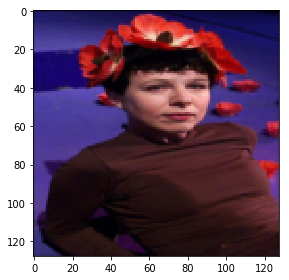

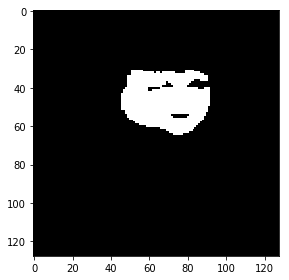

In [6]:
ix = random.randint(0, 100)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

D) Construct the UNET model

In [7]:
def skin_unet_model(X_train,Y_train,X_val,Y_val, params):
    IMG_WIDTH = 128
    IMG_HEIGHT = 128
    IMG_CHANNELS = 3    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.2) (c5)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
    u10 = concatenate([u10, c2], axis=3)
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u10)
    c10 = Dropout(0.1) (c10)
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u11)
    c11 = Dropout(0.1) (c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model = multi_gpu_model(model, gpus=4)
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer']))
                  ,loss='binary_crossentropy', metrics=['acc'],)
    earlystopper = EarlyStopping(patience=40, verbose=1)
    checkpointer = ModelCheckpoint('new_abdomen_paramopt_lr.h5', verbose=1, save_best_only=True)
    history = model.fit(X_train, Y_train, validation_split=0.20, batch_size=params['batch_size'], epochs=params['epochs'], shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])
    return history,model

In [8]:
skin_unet_model

<function __main__.skin_unet_model(X_train, Y_train, X_val, Y_val, params)>

In [10]:
p = {'lr': (0.1,1.5,10),
     'batch_size': [64],
     'epochs': [180],
     #'dropoutc4': [0.4],
 #    'dropoutc6': [0.4],
  #   'dropoutc8': [0.4],
#      'dropoutc6': (0.2, 0.6, 5),
#      'dropoutc8': (0.2, 0.6, 5),
     'optimizer': [Adam],
     }

In [11]:
# 'dropoutc6': (0.2, 0.6, 5),
#      'dropoutc8': (0.2, 0.6, 5),

In [13]:
t = ta.Scan(x=X_train,
            y=Y_train,
            model=skin_unet_model,
            params=p, debug=True,print_params= True)
ta.Deploy(t, 'new_abdomen_paramopt_lr_0.1to1.5')


  0%|          | 0/10 [00:00<?, ?it/s]

{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.6599999999999999, 'batch_size': 64}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 16s 3ms/step - loss: 4.7188 - acc: 0.7066 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00001: val_loss improved from inf to 4.68037, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6836 - acc: 0.7094 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00002: val_loss did not improve from 4.68037
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6836 - acc: 0.7094 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00003: val_loss did not improve from 4.68037
Epoch


Epoch 00038: val_loss did not improve from 4.68037
Epoch 39/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6836 - acc: 0.7094 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00039: val_loss did not improve from 4.68037
Epoch 40/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6836 - acc: 0.7094 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00040: val_loss did not improve from 4.68037
Epoch 41/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6836 - acc: 0.7094 - val_loss: 4.6804 - val_acc: 0.7096


 10%|█         | 1/10 [04:35<41:20, 275.66s/it]


Epoch 00041: val_loss did not improve from 4.68037
Epoch 00041: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.9399999999999998, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 4.7691 - acc: 0.7016 - val_loss: 4.6709 - val_acc: 0.7096

Epoch 00001: val_loss improved from inf to 4.67094, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 2.1168 - acc: 0.6991 - val_loss: 0.4793 - val_acc: 0.7092

Epoch 00002: val_loss improved from 4.67094 to 0.47926, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4341 - acc: 0.7089 - val_loss: 0.4162 - val_acc: 0.7095

Epoch 00003: val_loss improved from 0.47926 to 0.41622, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0628 - acc: 0.9759 - val_loss: 0.1527 - val_acc: 0.9526

Epoch 00081: val_loss did not improve from 0.12918
Epoch 82/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0623 - acc: 0.9761 - val_loss: 0.1425 - val_acc: 0.9549

Epoch 00082: val_loss did not improve from 0.12918
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0600 - acc: 0.9768 - val_loss: 0.1296 - val_acc: 0.9581

Epoch 00083: val_loss did not improve from 0.12918
Epoch 84/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0609 - acc: 0.9766 - val_loss: 0.1312 - val_acc: 0.9583

Epoch 00084: val_loss did not improve from 0.12918
Epoch 85/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0655 - acc: 0.9750 - val_loss: 0.1437 - val_acc: 0.9552

Epoch 00085: val_loss did not improve from 0.12918
Epoch 86/180
5096/5096 [==============================] - 6s 1ms/step - l

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0459 - acc: 0.9820 - val_loss: 0.1338 - val_acc: 0.9607

Epoch 00166: val_loss did not improve from 0.12387
Epoch 167/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0454 - acc: 0.9822 - val_loss: 0.1322 - val_acc: 0.9617

Epoch 00167: val_loss did not improve from 0.12387
Epoch 168/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0451 - acc: 0.9823 - val_loss: 0.1406 - val_acc: 0.9605

Epoch 00168: val_loss did not improve from 0.12387
Epoch 169/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0446 - acc: 0.9825 - val_loss: 0.1353 - val_acc: 0.9613

Epoch 00169: val_loss did not improve from 0.12387
Epoch 170/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0447 - acc: 0.9824 - val_loss: 0.1389 - val_acc: 0.9608

Epoch 00170: val_loss did not improve from 0.12387
Epoch 171/180
5096/5096 [==============================] - 6s 1ms/ste

 20%|██        | 2/10 [23:03<1:10:03, 525.45s/it]


Epoch 00180: val_loss did not improve from 0.12387
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 1.3599999999999999, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 1.2949 - acc: 0.6848 - val_loss: 0.4736 - val_acc: 0.7088

Epoch 00001: val_loss improved from inf to 0.47357, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4758 - acc: 0.7070 - val_loss: 0.4399 - val_acc: 0.7092

Epoch 00002: val_loss improved from 0.47357 to 0.43988, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4332 - acc: 0.7813 - val_loss: 0.4124 - val_acc: 0.7913

Epoch 00003: val_loss improved from 0.43988 to 0.41245, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.3907 - acc: 0


Epoch 00039: val_loss did not improve from 0.12205
Epoch 40/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0908 - acc: 0.9653 - val_loss: 0.1219 - val_acc: 0.9541

Epoch 00040: val_loss improved from 0.12205 to 0.12190, saving model to new_abdomen_paramopt_lr.h5
Epoch 41/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1045 - acc: 0.9609 - val_loss: 0.1211 - val_acc: 0.9544

Epoch 00041: val_loss improved from 0.12190 to 0.12115, saving model to new_abdomen_paramopt_lr.h5
Epoch 42/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0961 - acc: 0.9634 - val_loss: 0.1215 - val_acc: 0.9542

Epoch 00042: val_loss did not improve from 0.12115
Epoch 43/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0950 - acc: 0.9638 - val_loss: 0.1301 - val_acc: 0.9519

Epoch 00043: val_loss did not improve from 0.12115
Epoch 44/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0922 - acc: 0.9648 -

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0669 - acc: 0.9743 - val_loss: 0.1094 - val_acc: 0.9608

Epoch 00082: val_loss improved from 0.11251 to 0.10941, saving model to new_abdomen_paramopt_lr.h5
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0664 - acc: 0.9746 - val_loss: 0.1155 - val_acc: 0.9613

Epoch 00083: val_loss did not improve from 0.10941
Epoch 84/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0672 - acc: 0.9742 - val_loss: 0.1250 - val_acc: 0.9595

Epoch 00084: val_loss did not improve from 0.10941
Epoch 85/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0650 - acc: 0.9750 - val_loss: 0.1260 - val_acc: 0.9582

Epoch 00085: val_loss did not improve from 0.10941
Epoch 86/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0653 - acc: 0.9750 - val_loss: 0.1292 - val_acc: 0.9593

Epoch 00086: val_loss did not improve from 0.10941
Epoch 87/180
5096/5096 [=

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0556 - acc: 0.9786 - val_loss: 0.1113 - val_acc: 0.9625

Epoch 00125: val_loss did not improve from 0.10893
Epoch 126/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0565 - acc: 0.9783 - val_loss: 0.1128 - val_acc: 0.9615

Epoch 00126: val_loss did not improve from 0.10893
Epoch 127/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0574 - acc: 0.9779 - val_loss: 0.1235 - val_acc: 0.9610

Epoch 00127: val_loss did not improve from 0.10893
Epoch 128/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0588 - acc: 0.9775 - val_loss: 0.1304 - val_acc: 0.9596

Epoch 00128: val_loss did not improve from 0.10893
Epoch 129/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0565 - acc: 0.9783 - val_loss: 0.1109 - val_acc: 0.9630

Epoch 00129: val_loss did not improve from 0.10893
Epoch 130/180
5096/5096 [==============================] - 6s 1ms/ste

 30%|███       | 3/10 [37:01<1:12:14, 619.21s/it]


Epoch 00137: val_loss did not improve from 0.10893
Epoch 00137: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.24, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 3.5299 - acc: 0.7155 - val_loss: 1.4654 - val_acc: 0.7847

Epoch 00001: val_loss improved from inf to 1.46538, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 1.0230 - acc: 0.8121 - val_loss: 0.8704 - val_acc: 0.7341

Epoch 00002: val_loss improved from 1.46538 to 0.87042, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4577 - acc: 0.8188 - val_loss: 0.7046 - val_acc: 0.7029

Epoch 00003: val_loss improved from 0.87042 to 0.70460, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0

5096/5096 [==============================] - 6s 1ms/step - loss: 0.1038 - acc: 0.9591 - val_loss: 0.1747 - val_acc: 0.9378

Epoch 00039: val_loss improved from 0.18206 to 0.17469, saving model to new_abdomen_paramopt_lr.h5
Epoch 40/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1019 - acc: 0.9600 - val_loss: 0.1743 - val_acc: 0.9376

Epoch 00040: val_loss improved from 0.17469 to 0.17434, saving model to new_abdomen_paramopt_lr.h5
Epoch 41/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0978 - acc: 0.9615 - val_loss: 0.1780 - val_acc: 0.9377

Epoch 00041: val_loss did not improve from 0.17434
Epoch 42/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0969 - acc: 0.9617 - val_loss: 0.1713 - val_acc: 0.9392

Epoch 00042: val_loss improved from 0.17434 to 0.17128, saving model to new_abdomen_paramopt_lr.h5
Epoch 43/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0974 - acc: 0.9617 - val_loss: 0.1920

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0629 - acc: 0.9753 - val_loss: 0.1581 - val_acc: 0.9498

Epoch 00081: val_loss did not improve from 0.14751
Epoch 82/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0624 - acc: 0.9755 - val_loss: 0.1564 - val_acc: 0.9504

Epoch 00082: val_loss did not improve from 0.14751
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0624 - acc: 0.9756 - val_loss: 0.1489 - val_acc: 0.9517

Epoch 00083: val_loss did not improve from 0.14751
Epoch 84/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0624 - acc: 0.9755 - val_loss: 0.1544 - val_acc: 0.9510

Epoch 00084: val_loss did not improve from 0.14751
Epoch 85/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0607 - acc: 0.9762 - val_loss: 0.1509 - val_acc: 0.9531

Epoch 00085: val_loss did not improve from 0.14751
Epoch 86/180
5096/5096 [==============================] - 6s 1ms/step - l

 40%|████      | 4/10 [50:00<1:06:41, 666.92s/it]


Epoch 00128: val_loss did not improve from 0.13572
Epoch 00128: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.1, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 5.3470 - acc: 0.6621 - val_loss: 4.6818 - val_acc: 0.7095

Epoch 00001: val_loss improved from inf to 4.68183, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6897 - acc: 0.7089 - val_loss: 4.6805 - val_acc: 0.7096

Epoch 00002: val_loss improved from 4.68183 to 4.68055, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.6864 - acc: 0.7092 - val_loss: 4.6804 - val_acc: 0.7096

Epoch 00003: val_loss improved from 4.68055 to 4.68036, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/step - loss: 4.

 50%|█████     | 5/10 [54:39<45:53, 550.72s/it]  


Epoch 00044: val_loss did not improve from 4.68036
Epoch 00044: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 1.0799999999999998, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 1.1378 - acc: 0.7792 - val_loss: 0.4615 - val_acc: 0.7667

Epoch 00001: val_loss improved from inf to 0.46151, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.3512 - acc: 0.8564 - val_loss: 0.3964 - val_acc: 0.8263

Epoch 00002: val_loss improved from 0.46151 to 0.39640, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.2884 - acc: 0.8853 - val_loss: 0.3282 - val_acc: 0.8699

Epoch 00003: val_loss improved from 0.39640 to 0.32825, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0583 - acc: 0.9778 - val_loss: 0.1226 - val_acc: 0.9587

Epoch 00082: val_loss did not improve from 0.11579
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0558 - acc: 0.9785 - val_loss: 0.1200 - val_acc: 0.9602

Epoch 00083: val_loss did not improve from 0.11579
Epoch 84/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0612 - acc: 0.9765 - val_loss: 0.1242 - val_acc: 0.9583

Epoch 00084: val_loss did not improve from 0.11579
Epoch 85/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0602 - acc: 0.9769 - val_loss: 0.1243 - val_acc: 0.9571

Epoch 00085: val_loss did not improve from 0.11579
Epoch 86/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0584 - acc: 0.9777 - val_loss: 0.1240 - val_acc: 0.9589

Epoch 00086: val_loss did not improve from 0.11579
Epoch 87/180
5096/5096 [==============================] - 6s 1ms/step - l

 60%|██████    | 6/10 [1:06:42<40:09, 602.27s/it]


Epoch 00118: val_loss did not improve from 0.11579
Epoch 00118: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 1.22, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 4.7171 - acc: 0.7059 - val_loss: 4.6769 - val_acc: 0.7096

Epoch 00001: val_loss improved from inf to 4.67691, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 3.4698 - acc: 0.7192 - val_loss: 0.5551 - val_acc: 0.6996

Epoch 00002: val_loss improved from 4.67691 to 0.55510, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4668 - acc: 0.7932 - val_loss: 0.4099 - val_acc: 0.8183

Epoch 00003: val_loss improved from 0.55510 to 0.40987, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0

5096/5096 [==============================] - 6s 1ms/step - loss: 0.1003 - acc: 0.9620 - val_loss: 0.1278 - val_acc: 0.9540

Epoch 00079: val_loss did not improve from 0.12126
Epoch 80/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1071 - acc: 0.9593 - val_loss: 0.1394 - val_acc: 0.9490

Epoch 00080: val_loss did not improve from 0.12126
Epoch 81/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1016 - acc: 0.9614 - val_loss: 0.1172 - val_acc: 0.9565

Epoch 00081: val_loss improved from 0.12126 to 0.11720, saving model to new_abdomen_paramopt_lr.h5
Epoch 82/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0983 - acc: 0.9627 - val_loss: 0.1196 - val_acc: 0.9560

Epoch 00082: val_loss did not improve from 0.11720
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0958 - acc: 0.9636 - val_loss: 0.1236 - val_acc: 0.9551

Epoch 00083: val_loss did not improve from 0.11720
Epoch 84/180
5096/5096 [=

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0693 - acc: 0.9736 - val_loss: 0.1197 - val_acc: 0.9593

Epoch 00164: val_loss did not improve from 0.10436
Epoch 165/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0688 - acc: 0.9738 - val_loss: 0.1139 - val_acc: 0.9614

Epoch 00165: val_loss did not improve from 0.10436
Epoch 166/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0671 - acc: 0.9744 - val_loss: 0.1139 - val_acc: 0.9605

Epoch 00166: val_loss did not improve from 0.10436
Epoch 167/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0674 - acc: 0.9743 - val_loss: 0.1211 - val_acc: 0.9599

Epoch 00167: val_loss did not improve from 0.10436
Epoch 168/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0679 - acc: 0.9740 - val_loss: 0.1142 - val_acc: 0.9614

Epoch 00168: val_loss did not improve from 0.10436
Epoch 169/180
5096/5096 [==============================] - 6s 1ms/ste

 70%|███████   | 7/10 [1:23:59<36:37, 732.63s/it]


Epoch 00170: val_loss did not improve from 0.10436
Epoch 00170: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.7999999999999999, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 1.0928 - acc: 0.6840 - val_loss: 0.4829 - val_acc: 0.7555

Epoch 00001: val_loss improved from inf to 0.48292, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4086 - acc: 0.8412 - val_loss: 0.4763 - val_acc: 0.7693

Epoch 00002: val_loss improved from 0.48292 to 0.47628, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.3631 - acc: 0.8716 - val_loss: 0.4115 - val_acc: 0.8317

Epoch 00003: val_loss improved from 0.47628 to 0.41150, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/


Epoch 00038: val_loss did not improve from 0.15073
Epoch 39/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1109 - acc: 0.9587 - val_loss: 0.1480 - val_acc: 0.9470

Epoch 00039: val_loss improved from 0.15073 to 0.14798, saving model to new_abdomen_paramopt_lr.h5
Epoch 40/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1003 - acc: 0.9623 - val_loss: 0.1420 - val_acc: 0.9474

Epoch 00040: val_loss improved from 0.14798 to 0.14202, saving model to new_abdomen_paramopt_lr.h5
Epoch 41/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0919 - acc: 0.9657 - val_loss: 0.1545 - val_acc: 0.9464

Epoch 00041: val_loss did not improve from 0.14202
Epoch 42/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0840 - acc: 0.9686 - val_loss: 0.1539 - val_acc: 0.9475

Epoch 00042: val_loss did not improve from 0.14202
Epoch 43/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0809 - acc: 0.9696 -

 80%|████████  | 8/10 [1:33:34<22:50, 685.34s/it]


Epoch 00094: val_loss did not improve from 0.13127
Epoch 00094: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.38, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 4.6820 - acc: 0.7093 - val_loss: 4.6520 - val_acc: 0.7094

Epoch 00001: val_loss improved from inf to 4.65201, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 1.2997 - acc: 0.6439 - val_loss: 0.6375 - val_acc: 0.7091

Epoch 00002: val_loss improved from 4.65201 to 0.63753, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.5076 - acc: 0.7083 - val_loss: 0.6112 - val_acc: 0.7091

Epoch 00003: val_loss improved from 0.63753 to 0.61115, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0702 - acc: 0.9753 - val_loss: 0.1428 - val_acc: 0.9506

Epoch 00078: val_loss did not improve from 0.13889
Epoch 79/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0694 - acc: 0.9755 - val_loss: 0.2066 - val_acc: 0.9304

Epoch 00079: val_loss did not improve from 0.13889
Epoch 80/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1041 - acc: 0.9627 - val_loss: 0.1699 - val_acc: 0.9373

Epoch 00080: val_loss did not improve from 0.13889
Epoch 81/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0921 - acc: 0.9666 - val_loss: 0.1522 - val_acc: 0.9462

Epoch 00081: val_loss did not improve from 0.13889
Epoch 82/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0716 - acc: 0.9744 - val_loss: 0.1390 - val_acc: 0.9517

Epoch 00082: val_loss did not improve from 0.13889
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - l


Epoch 00120: val_loss did not improve from 0.12878
Epoch 121/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0490 - acc: 0.9812 - val_loss: 0.1441 - val_acc: 0.9549

Epoch 00121: val_loss did not improve from 0.12878
Epoch 122/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0486 - acc: 0.9813 - val_loss: 0.1456 - val_acc: 0.9558

Epoch 00122: val_loss did not improve from 0.12878
Epoch 123/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0484 - acc: 0.9814 - val_loss: 0.1508 - val_acc: 0.9538

Epoch 00123: val_loss did not improve from 0.12878
Epoch 124/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0484 - acc: 0.9813 - val_loss: 0.1447 - val_acc: 0.9554

Epoch 00124: val_loss did not improve from 0.12878
Epoch 125/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0500 - acc: 0.9808 - val_loss: 0.1415 - val_acc: 0.9562

Epoch 00125: val_loss did not improve from 0.12878
Epo

 90%|█████████ | 9/10 [1:48:05<12:21, 741.09s/it]


Epoch 00146: val_loss did not improve from 0.12878
Epoch 00146: early stopping
{'epochs': 180, 'optimizer': <class 'keras.optimizers.Adam'>, 'lr': 0.5199999999999999, 'batch_size': 64}
Train on 5096 samples, validate on 1274 samples
Epoch 1/180
5096/5096 [==============================] - 10s 2ms/step - loss: 1.6386 - acc: 0.7341 - val_loss: 0.5519 - val_acc: 0.7033

Epoch 00001: val_loss improved from inf to 0.55192, saving model to new_abdomen_paramopt_lr.h5
Epoch 2/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4717 - acc: 0.7744 - val_loss: 0.5302 - val_acc: 0.6314

Epoch 00002: val_loss improved from 0.55192 to 0.53017, saving model to new_abdomen_paramopt_lr.h5
Epoch 3/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.4294 - acc: 0.8162 - val_loss: 0.4718 - val_acc: 0.7340

Epoch 00003: val_loss improved from 0.53017 to 0.47177, saving model to new_abdomen_paramopt_lr.h5
Epoch 4/180
5096/5096 [==============================] - 6s 1ms/


Epoch 00037: val_loss did not improve from 0.14976
Epoch 38/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1120 - acc: 0.9633 - val_loss: 0.1548 - val_acc: 0.9467

Epoch 00038: val_loss did not improve from 0.14976
Epoch 39/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1152 - acc: 0.9614 - val_loss: 0.1530 - val_acc: 0.9465

Epoch 00039: val_loss did not improve from 0.14976
Epoch 40/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1072 - acc: 0.9641 - val_loss: 0.1465 - val_acc: 0.9490

Epoch 00040: val_loss improved from 0.14976 to 0.14645, saving model to new_abdomen_paramopt_lr.h5
Epoch 41/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1044 - acc: 0.9649 - val_loss: 0.1463 - val_acc: 0.9495

Epoch 00041: val_loss improved from 0.14645 to 0.14631, saving model to new_abdomen_paramopt_lr.h5
Epoch 42/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.1012 - acc: 0.9657 -

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0580 - acc: 0.9780 - val_loss: 0.1438 - val_acc: 0.9541

Epoch 00079: val_loss did not improve from 0.13379
Epoch 80/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0572 - acc: 0.9782 - val_loss: 0.1443 - val_acc: 0.9542

Epoch 00080: val_loss did not improve from 0.13379
Epoch 81/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0574 - acc: 0.9782 - val_loss: 0.1498 - val_acc: 0.9526

Epoch 00081: val_loss did not improve from 0.13379
Epoch 82/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0580 - acc: 0.9779 - val_loss: 0.1402 - val_acc: 0.9551

Epoch 00082: val_loss did not improve from 0.13379
Epoch 83/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0560 - acc: 0.9786 - val_loss: 0.1506 - val_acc: 0.9525

Epoch 00083: val_loss did not improve from 0.13379
Epoch 84/180
5096/5096 [==============================] - 6s 1ms/step - l

5096/5096 [==============================] - 6s 1ms/step - loss: 0.0455 - acc: 0.9823 - val_loss: 0.1468 - val_acc: 0.9564

Epoch 00122: val_loss did not improve from 0.13219
Epoch 123/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0453 - acc: 0.9824 - val_loss: 0.1428 - val_acc: 0.9582

Epoch 00123: val_loss did not improve from 0.13219
Epoch 124/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0447 - acc: 0.9826 - val_loss: 0.1453 - val_acc: 0.9576

Epoch 00124: val_loss did not improve from 0.13219
Epoch 125/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0446 - acc: 0.9826 - val_loss: 0.1404 - val_acc: 0.9590

Epoch 00125: val_loss did not improve from 0.13219
Epoch 126/180
5096/5096 [==============================] - 6s 1ms/step - loss: 0.0453 - acc: 0.9824 - val_loss: 0.1463 - val_acc: 0.9577

Epoch 00126: val_loss did not improve from 0.13219
Epoch 127/180
5096/5096 [==============================] - 6s 1ms/ste

100%|██████████| 10/10 [2:02:48<00:00, 783.73s/it]


Epoch 00142: val_loss did not improve from 0.13219
Epoch 00142: early stopping


Deploy package new_abdomen_paramopt_lr_0.1to1.5 have been saved.


ValueError: Must pass 2-d input

In [28]:
# a = ta.Restore(path_to_zip ='new_abdomen_paramopt_lr/')
r = ta.Reporting('new_abdomen_paramopt_lr_optimizer.csv')

In [43]:
r.rounds2high()

5

In [53]:
p = ta.Predict(t)


In [69]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('./new_abdomen_paramopt_lr_optimizer/new_abdomen_paramopt_lr_optimizer_model.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('./new_abdomen_paramopt_lr_optimizer/new_abdomen_paramopt_lr_optimizer_model.h5')

In [40]:
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = {'lr': np.random.uniform(0.00001,0.2,100)}
# modeliter = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=10,scoring='accuracy')

## E) Fit the model to the training data

F) Output training results

In [42]:
# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

NameError: name 'results' is not defined

G) Test against training and validation samples

In [55]:
# model = load_model('your_model_name.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1707/1707 [==============================] - 1s 719us/step


H) See predicted masks for training samples

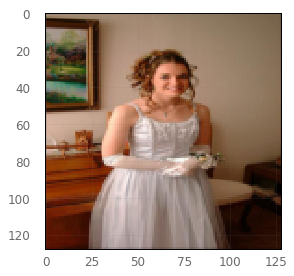

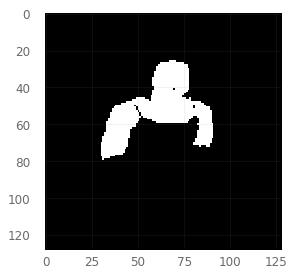

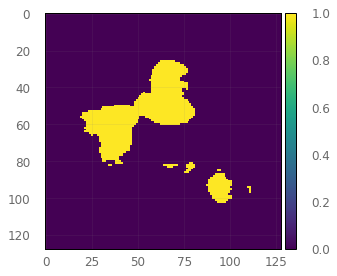

In [56]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

I) See predicted masks for validation data

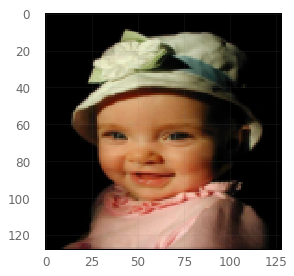

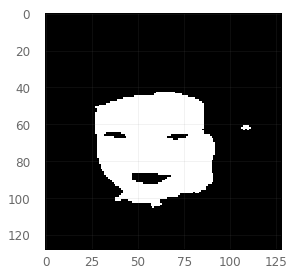

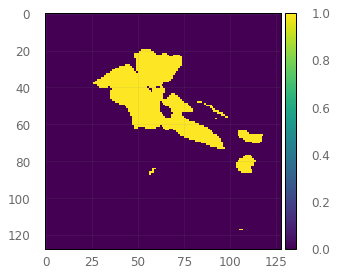

In [60]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.7):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

J) Load model, testing data and check against trained network (if masks exist)

In [ ]:
model = load_model('your_model_name.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'

abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only   
    else:   
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
answer = acc_comp(msk, preds_test_t);

# # Save results in a .npy file
# a = np.reshape(answer[2],(100,1))
# b = np.reshape(answer[3],(100,1))
# c = np.reshape(answer[4],(100,1))
# d = np.reshape(answer[5],(100,1))
# g = np.concatenate([a,b,c,d],axis = 1)
# np.save('your_file_name.npy',g)

K) Visualize results

In [ ]:
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()
    imshow(np.squeeze(msk[j]))

J') Load model, testing data and check against trained network (if masks do NOT exist)

In [ ]:
model = load_model('lydia.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = '/home/lalzogbi/Documents/Umbilicus_Skin_Detection/code/wounds/'

abd_ids = next(os.walk(ABD_PATH))[2]
abd_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

K') Visualize results

In [ ]:
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()